In [1]:
import os
for root, dirs, files in os.walk('/kaggle/input'):
    level = root.replace('/kaggle/input', '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')

input/
    dogs-skin-diseases-image-dataset/
        valid/
            Dermatitis/
            demodicosis/
            Healthy/
            Hypersensitivity/
            Fungal_infections/
            ringworm/
        test/
            Dermatitis/
            demodicosis/
            Healthy/
            Hypersensitivity/
            Fungal_infections/
            ringworm/
        train/
            Dermatitis/
            demodicosis/
            Healthy/
            Hypersensitivity/
            Fungal_infections/
            ringworm/


/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using 2 GPUs
Detected Classes: ['Dermatitis', 'Fungal_infections', 'Healthy', 'Hypersensitivity', 'demodicosis', 'ringworm']
Loading Model


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Pretrained weights loaded
Starting training for 10 epochs
Epoch 1/10 - Loss: 0.7691
Epoch 2/10 - Loss: 0.2210
Epoch 3/10 - Loss: 0.1079
Epoch 4/10 - Loss: 0.0610
Epoch 5/10 - Loss: 0.0501
Epoch 6/10 - Loss: 0.0406
Epoch 7/10 - Loss: 0.0408
Epoch 8/10 - Loss: 0.0461
Epoch 9/10 - Loss: 0.0350
Epoch 10/10 - Loss: 0.0239
Evaluating model on validation set


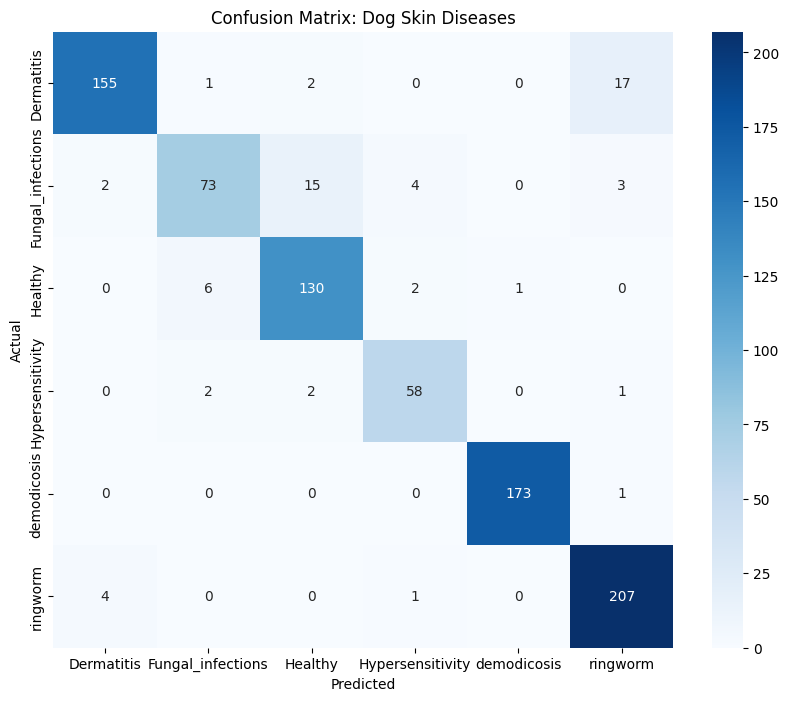

Confusion Matrix saved as 'dog_skin_confusion_matrix.png'

Classification Report
                   precision    recall  f1-score   support

       Dermatitis       0.96      0.89      0.92       175
Fungal_infections       0.89      0.75      0.82        97
          Healthy       0.87      0.94      0.90       139
 Hypersensitivity       0.89      0.92      0.91        63
      demodicosis       0.99      0.99      0.99       174
         ringworm       0.90      0.98      0.94       212

         accuracy                           0.93       860
        macro avg       0.92      0.91      0.91       860
     weighted avg       0.93      0.93      0.92       860

Statistics saved as 'dog_skin_report.txt'
Model 'Brain' saved to /kaggle/working/dog_skin_vit_model.pth


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import warnings
import os

warnings.filterwarnings("ignore",category=UserWarning,module='pydantic')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count()
print(f"Using {num_gpus} GPUs")


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]) ])

base_path='/kaggle/input/dogs-skin-diseases-image-dataset'
train_path=f'{base_path}/train'
valid_path=f'{base_path}/valid'

train_dataset=datasets.ImageFolder(train_path,transform=transform)
valid_dataset=datasets.ImageFolder(valid_path,transform=transform)

train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=4,pin_memory=True)
valid_loader=DataLoader(valid_dataset,batch_size=64,shuffle=False,num_workers=4,pin_memory=True)

class_names=train_dataset.classes
print(f"Detected Classes: {class_names}")


print("Loading Model")
model = timm.create_model('vit_tiny_patch16_224',pretrained=True,num_classes=len(class_names))
print("Pretrained weights loaded")

#Multi-GPU
if num_gpus>1:
    model = nn.DataParallel(model)
model=model.to(device)

#Optimizer and Loss
criterion=nn.CrossEntropyLoss()
optimizer=optim.AdamW(model.parameters(),lr=0.0001,weight_decay=0.01)

#Training
epochs = 10
print(f"Starting training for {epochs} epochs")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images,labels in train_loader:
        images,labels=images.to(device),labels.to(device)
        
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f}")

model.eval()
all_preds=[]
all_labels=[]

print("Evaluating model on validation set")
with torch.no_grad():
    for images,labels in valid_loader:
        images,labels = images.to(device),labels.to(device)
        outputs=model(images)
        _,preds=torch.max(outputs,1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#Visualization 
plt.figure(figsize=(10,8))
cm = confusion_matrix(all_labels,all_preds)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.title("Confusion Matrix: Dog Skin Diseases")
plt.xlabel("Predicted")
plt.ylabel("Actual")


plt.savefig('dog_skin_confusion_matrix.png') 
plt.show()
print("Confusion Matrix saved as 'dog_skin_confusion_matrix.png'")

report=classification_report(all_labels,all_preds,target_names=class_names)
print("\nClassification Report")
print(report)

with open("dog_skin_report.txt","w") as f:
    f.write(report)
print("Statistics saved as 'dog_skin_report.txt'")

torch.save(model.state_dict(),'dog_skin_vit_model.pth')
print("Model saved to /kaggle/working/dog_skin_vit_model.pth")